In [1]:
import os 
os.chdir("..")


In [5]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=dtt, total_time=total_time)

In [40]:

mode = "frequencies"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

dtt = 1e-6
total_time = 50

total_time, dt = get_total_time_dt(params, dt=dtt, total_time=total_time)
times = np.arange(0, total_time+ dt, dt)


Ntraj = 10000
boundsB= np.arange(.1,10,1.)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

er=[]
deter = {}
deter["h0/h1"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]



n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=dtt, total_time=total_time)

        for indb,b in enumerate(boundsB):
            stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
            stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b, times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b
                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))

100%|██████████| 9999/9999 [00:18<00:00, 537.48it/s]  


8999

In [41]:
stops1 = []
for k in stop["_1"].values():
    if len(k) != 0:
        stops1.append(k)
stops1 = np.squeeze(stops1)

stops0 = []
for k in stop["_0"].values():
    if len(k) != 0:
        stops0.append(k)
stops0 = np.squeeze(stops0)


cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(boundsB):
    counts1, bins1 = np.histogram(stops1[:,indb][~np.isnan(stops1[:,indb])], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[:,indb][~np.isnan(stops0[:,indb])], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


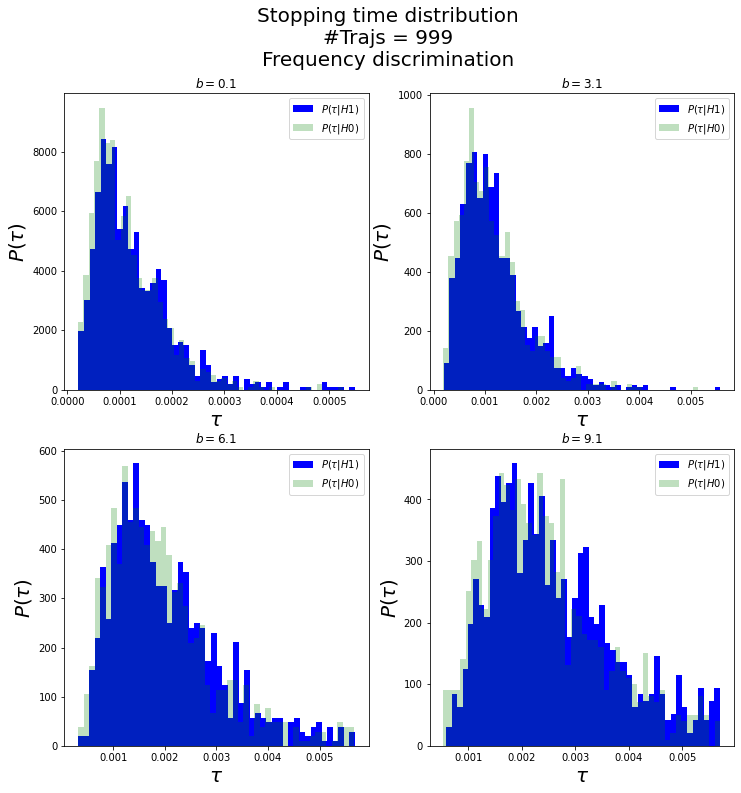

In [42]:
plt.figure(figsize=(12,12))
plt.suptitle("Stopping time distribution\n#Trajs = {}\nFrequency discrimination".format(len(stops)),size=20)
axx = [221, 222, 223, 224]
selected_b = [boundsB[int(k)] for k in np.linspace(0,len(boundsB)-1, 4)]
for indb, b in enumerate(selected_b):
    ax = plt.subplot(axx[indb])
    ax.set_title('$b=$'+str(np.round(b,2)))
    ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="blue", alpha=1,label=r'$P(\tau|H1)$')
    ax.bar(timbin0[indb], cons0[indb], width=timbin0[indb][1]-timbin0[indb][0], color="green", alpha=0.25, label=r'$P(\tau|H0)$')
    
    ax.set_xlabel(r'$\tau$',size=20)
    ax.set_ylabel(r'$P(\tau)$', size=20)
    ax.legend(prop={"size":10})
#plt.savefig(path+"stopping_times.pdf")